# TEXT DATA EXPLORATION AND PRE-PROCESSING

(Hussain et al., 2020) It has been observed from the literature that Spam Review detection using linguistic method uses only review text for spotting the spam review [37], [38]. It is usually performed binary classifcation in which the review is classifed as``spam or not spam``, and in our case studying the verified and unverified reviews for the detection of fake reviews.

## SUMMARY

In this notebook, we have done another EDA, however this time we focused on the input variable review_text itself, rather than the other attributes. Firstly columns depicting the character, word, stopcount, punctuation and the capital letter counts were added to guage the frequency of each of them, which then we later cleaned them during the text processing stage. 

It is important to note that before that, the necessary duplicates and NULL values were also taken care of, and then the reviews were then saved into a new file, where in the next notebook it is going to be utlized for model building.

----------------------------------------------------------------------

## INITIALIZATION

In [19]:
#LIBRARIES 
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import  PorterStemmer 
import string
import re
import warnings
warnings.simplefilter("ignore")

In [4]:
pip install textblob



     -------------------------------------- 636.8/636.8 kB 4.0 MB/s eta 0:00:00


In [5]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [18]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [8]:
#lOADING DATASET 
df = pd.read_csv("updated_data.csv",encoding="latin1") #due to special charas should be encoded as latin 1
#REMOVE MAX
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
pip install wordcloud



     ---------------------------------------- 153.3/153.3 kB ? eta 0:00:00


In [9]:
df.head()

,Unnamed: 0,review_date,review_rating,review_title,review_text,verified_purchase
0,0,1/1/2019,5,Dove MenÂs + Deodorant,"As you get older, you know what you like and w...",True
1,1,1/2/2019,5,Great for a marmite lover!,Three gigantic marmite jars that will last pro...,True
2,2,1/2/2019,4,Vitamin B12.,Excellent,True
3,3,1/2/2019,5,A Very Handy Flavour Top - Up to Keep In The C...,A great flavour top - up for slow cooking.,True
4,4,1/2/2019,5,Very handy,Does what is says it does,False


In [10]:
#DROPPING UNWANTED COLUMN
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2501 entries, 0 to 2500
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   review_date        2501 non-null   object
 1   review_rating      2501 non-null   int64 
 2   review_title       2403 non-null   object
 3   review_text        2501 non-null   object
 4   verified_purchase  2501 non-null   bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 80.7+ KB


## RE-CHECK NULL AND DUPLICATES

In our first EDA with the entire dataset, the duplicates within the reviews were not detected, which could be due to the other columns having slightly different values. Since we have removed the other columns and all we have left are the review_centric values, we need to double check on whether there are duplicated reviews within the dataset, which we can remove accordingly to remove potential bias.

### Removing Duplicates

Initially, in the first data exploration in the old cvs file, we have tried finding out the duplicates within this dataset. However, initially it did not yield any results. To double check on whether this dataset really has no duplicates, the selected columns were added to aid see if there are actually any duplicates within this dataset. 

In [11]:
#CHECK TOTAL DUPLICATE OCCURENCES
dup = df.duplicated().sum()
print("Number of duplicates in dataset: ", dup)

Number of duplicates in dataset:  783


In [12]:
df = df.drop_duplicates().reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1718 entries, 0 to 1717
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   review_date        1718 non-null   object
 1   review_rating      1718 non-null   int64 
 2   review_title       1652 non-null   object
 3   review_text        1718 non-null   object
 4   verified_purchase  1718 non-null   bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 55.5+ KB


### NULL Values
re-checking for NULL values to check if any needs to be filled up or dropped.

In [13]:
df.isnull().sum()

review_date           0
review_rating         0
review_title         66
review_text           0
verified_purchase     0
dtype: int64

In [14]:
#DROP review_title
df.drop(["review_title","review_date"], axis=1, 
        inplace=True)
df.head()

,review_rating,review_text,verified_purchase
0,5,"As you get older, you know what you like and w...",True
1,5,Three gigantic marmite jars that will last pro...,True
2,4,Excellent,True
3,5,A great flavour top - up for slow cooking.,True
4,5,Does what is says it does,False


Titles are actually not mandatory in amazon reviews, and hence there are multiple missing values within the review_title. For this project, we are not going to be utlizing this dataset, and hence it is going to be dropped.

## EDA ON THE REVIEW TEXT

We have conducted an in-depth review surrounding the background of the Amazon dataset, and this time the ``review_text`` itself is going to be taken a further look. To aid in our pre-processing, certain columns will be added to understand certain instances the sentences have. Those include the counts of:
1. Word
2. Characters (with spaces)
3. Stopwords
4. Punctuations
5. Uppercase characters

After the columns are added, necessary ``summary statistics`` will be conducted to get an idea on how the pre-processing will take place.

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [22]:
#WORD COUNT
df['total words'] = df['review_text'].apply(lambda i: len(str(i).split(" ")))

#CHARACTER COUNT
df['total characters'] = df['review_text'].str.len() #spaces are included

#STOPWORDS COUNT
sw = set(stopwords.words('english'))
df['total stopwords'] = df['review_text'].str.split().apply(lambda i: len(set(i) & sw))

#PUNCTUATION AND SPECIAL CHARA COUNT
count_p = lambda p1,p2: sum([1 for i in p1 if i in p2])
df['total punctuations'] = df.review_text.apply(lambda p: count_p(p, string.punctuation))

#UPPERCASE CHARA COUNT
df['total uppercases'] = df['review_text'].str.findall(r'[A-Z]').str.len() #findall - finds all

In [24]:
df.head() #UPDATED 

,review_rating,review_text,verified_purchase,total words,total characters,total stopwords,total punctuations,total uppercases
0,5,"As you get older, you know what you like and w...",True,39,202,10,7,5
1,5,Three gigantic marmite jars that will last pro...,True,30,175,7,6,4
2,4,Excellent,True,1,9,0,0,1
3,5,A great flavour top - up for slow cooking.,True,9,42,2,2,1
4,5,Does what is says it does,False,6,25,4,0,1


### Summary Statistics

In [25]:
df.describe()

,review_rating,total words,total characters,total stopwords,total punctuations,total uppercases
count,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000
mean,4.441793,33.198487,177.890570,9.257276,4.434226,3.710128
std,1.123083,35.251879,189.818467,8.537092,5.177685,4.209264
min,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000
25%,4.000000,7.000000,41.000000,2.000000,1.000000,1.000000
50%,5.000000,21.000000,114.500000,7.000000,3.000000,2.000000
75%,5.000000,50.000000,268.750000,15.000000,7.000000,5.000000
max,5.000000,287.000000,1624.000000,48.000000,42.000000,54.000000


> Readings
1. The mean characters within the entire dataset happens to be at 177, averaging at about 33 words per review.
2. On average, there are about 9 stop words, and within the sentences there are about 4 punctuations.
3. As for the uppercase letters, from the mean value it is safe to assume that most of the reviews utlized their uppercases as Sentence Case.

In [26]:
print(df.groupby("verified_purchase").describe())

                  review_rating                                               \
                          count      mean       std  min  25%  50%  75%  max   
verified_purchase                                                              
False                     900.0  4.315556  1.187805  1.0  4.0  5.0  5.0  5.0   
True                      818.0  4.580685  1.030249  1.0  5.0  5.0  5.0  5.0   

                  total words                                               \
                        count       mean        std  min   25%   50%   75%   
verified_purchase                                                            
False                   900.0  50.271111  36.854098  1.0  23.0  48.0  63.0   
True                    818.0  14.414425  21.041211  1.0   3.0   8.0  17.0   

                         total characters                                      \
                     max            count        mean         std  min    25%   
verified_purchase                             

> Findings
1. Overall, we can see that False reviews have more words per character than True Values, where False values have an average of 50 words and 268 characters, while True values have about 14 words on average and 77 characters per review.
2. Witin the Fake reviews, it can be observed that there are more stopwords as well, than True reviews.
3. Since they are longer sentences in False values, it can be seen that there are more punctuations and Sentence case than True values.


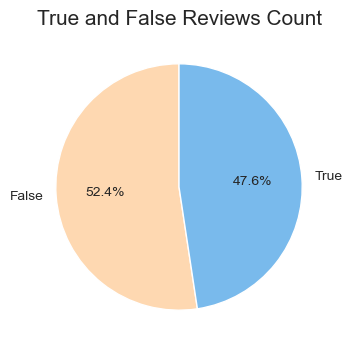

In [27]:
#PIE CHART ON VERFIED PURCHASES -two
colors = ['#FED8B1','#79BAEC']
plt.figure(figsize=(4,4))
label = df['verified_purchase'].value_counts()
plt.pie(label.values,colors = colors, labels=label.index, autopct= '%1.1f%%', startangle=90)
plt.title('True and False Reviews Count', fontsize=15)
plt.show()

After dropping the duplicates, we can see that the percentages of the True and False values are still near equal, and hence we can say that the dataset is balanced. Taking a closer look into the graph, there are more False values and True values within the dataset now.

Text(0.5, 1.0, 'Review_Rating Grouped by Verified_Purchase')

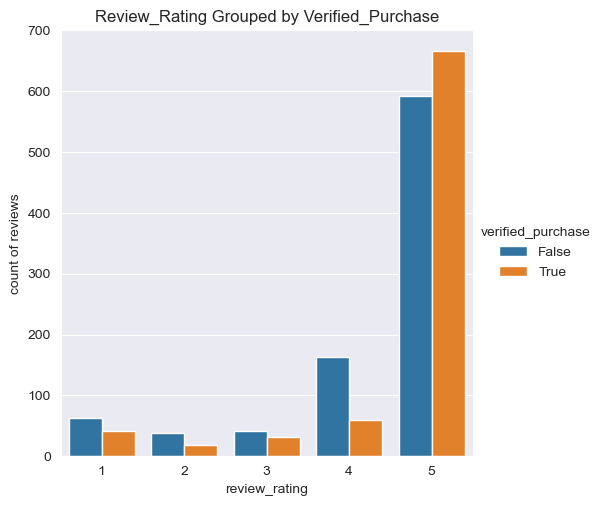

In [28]:
sns.catplot(x ='review_rating',kind="count", hue="verified_purchase", data=df)
plt.xlabel("review_rating")
plt.ylabel("count of reviews")
plt.title("Review_Rating Grouped by Verified_Purchase")

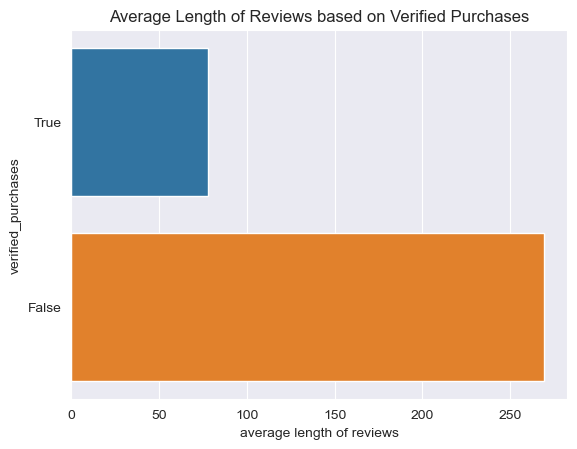

In [29]:
cols = ["verified_purchase", "review_text"]
vprt = df[cols] #making a subset of the dataframe-

#FILTERING BASED ON TRUE AND FALSE VP
checkTrue = vprt["verified_purchase"] == True
filtered_true = vprt[checkTrue]

checkFalse = vprt["verified_purchase"] == False
filtered_false = vprt[checkFalse]


#AVERAGE REVIEW LENGTH BASED ON TRUE AND FALSE VP
false_average_length = filtered_false["review_text"].apply(len).mean()
true_average_length = filtered_true["review_text"].apply(len).mean()

#PLOTTING THE GRAPH
x = [true_average_length,false_average_length]
y = ["True", "False"]
sns.barplot(x, y)
plt.xlabel("average length of reviews")
plt.ylabel("verified_purchases")
plt.title("Average Length of Reviews based on Verified Purchases")
plt.show()

From above we can see that 5 star rating is still the highest, and that true reviews still are more than false values within 5 star. Sentiment is still highly positive within this dataset.

## PRE-PROCESSING

Text preprocessing is a technique for cleaning text data and preparing it for use in a model. Text data comprises noise in the form of emotions, punctuation, and text in a different case, among other things. When it comes to Human Language, there are many different ways to communicate the same thing, and this is only the beginning of the difficulty. Machines cannot comprehend words; they want numbers, thus we must convert text to numbers efficiently.


From the summary statistics conducted, we can see that the noise mentioned are having occurences within the review text, and hence the pre-processing will be conducted accordingly.

> To Do
1. Drop unwanted columns
2. Lowercasing
3. Remove Stopwords
4. Remove Punctuations and Special charas
5. Stemming

In [30]:
#DROP UNNECESSARY COLUMNS
df.drop(["total words","total characters",
         "total stopwords","total punctuations",
         "total uppercases","review_rating"], axis=1, inplace=True)
df.head()

,review_text,verified_purchase
0,"As you get older, you know what you like and w...",True
1,Three gigantic marmite jars that will last pro...,True
2,Excellent,True
3,A great flavour top - up for slow cooking.,True
4,Does what is says it does,False


For now, we are going to be only utlizing review_text and verified_purchase for our classifiers.

### Text Pre-Processing 

The ``review_text`` is going to be cleaned and standardized so that when implemented within the model, the model can be optimized at its best. This step takes the longest since it is in base of trial and error.

DONE IN THIS STAGE:
1. Spelling is corrected
2. tokenization,
3. removing stopwords, punctuations, special charas
4. lowercasing
5. stemming
6. removing top 3 common and rare words


In [47]:
#CORRECT SPELLING
df.review_text.apply(lambda i: ''.join(TextBlob(i).correct()))

0       Is you get older, you know what you like and w...
1       Three gigantic marie wars that will last proba...
2                                               Excellent
3              A great flavour top - up for slow cooking.
4                               Does what is says it does
5                             Excellent item.Good for men
6                               Thank you ofm very happy
7                                               Beautiful
8                                 Always buy. Fig bottles
9       Always use this product on my heavily mistreat...
10                                            Great value
11      tos not the one in the picture, but gets 5 st...
12      Stem as described, excellent quality, rapid de...
13             Good body wash but not a very strong smell
14                                                  Great
15                                              North it!
16      I remember trying this at a friends house year...
17            

In [31]:
#REMOVING THE STOPWORDS,PUNCTUATIONS, LOWERCASING, AND STEMMING OF THE SENTENCES
def text_preprocessing(text):
    removed_special_characters = re.sub("[^a-zA-Z]", " ", str(text))
    tokens = removed_special_characters.lower().split()
    
    stemmer = PorterStemmer()
    cleaned = []
    stemmed = []
    
    for token in tokens:
        if token not in sw:
            cleaned.append(token)
            
    for token in cleaned:
        token = stemmer.stem(token)
        stemmed.append(token)

    return " ".join(stemmed)

In [32]:
df['review_text'] = df['review_text'].apply(text_preprocessing)

In [33]:
df['review_text'].head()

0    get older know like suitabl bodi like dove pro...
1    three gigant marmit jar last probabl whole lif...
2                                                excel
3                          great flavour top slow cook
4                                                  say
Name: review_text, dtype: object

In [34]:
#CHECK RARE WORDS
r = pd.Series(' '.join(df['review_text']).split()).value_counts()[-10:]
print("RARE WORDS:")
print(r)

RARE WORDS:
accident     1
chuck        1
emigr        1
salt         1
mushroom     1
fli          1
cult         1
revitalis    1
advantag     1
tendon       1
dtype: int64


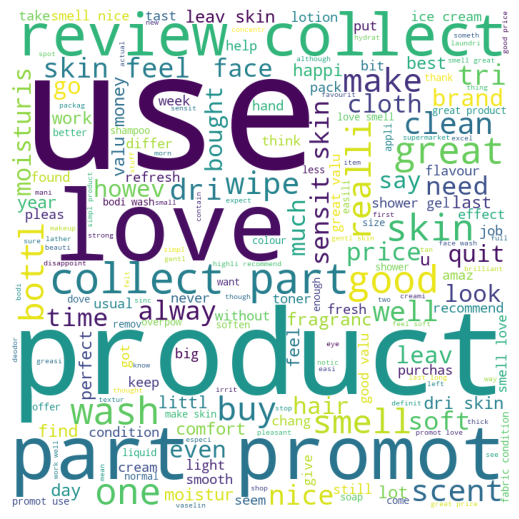

In [35]:
#CHECK TOP COMMON WORDS
words = '' 
for i in df["review_text"]: 
    tokens = i.split()   
    words += " ".join(tokens)+" "

    
word_cloud = WordCloud(width = 700, height = 700, 
                       background_color ='white', 
                       min_font_size = 10).generate(words) 
plt.figure(figsize = (5, 5)) 
plt.imshow(word_cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [36]:
#removing common and rare words
common = pd.Series(' '.join(df['review_text']).split()).value_counts()[:3]
common = list(common.index)
df['review_text'] = df['review_text'].apply(lambda i: " ".join(i for i in i.split() if i not in common))

rare = pd.Series(' '.join(df['review_text']).split()).value_counts()[-3:]
rare = list(rare.index)
df['review_text'] = df['review_text'].apply(lambda i: " ".join(i for i in i.split() if i not in rare))

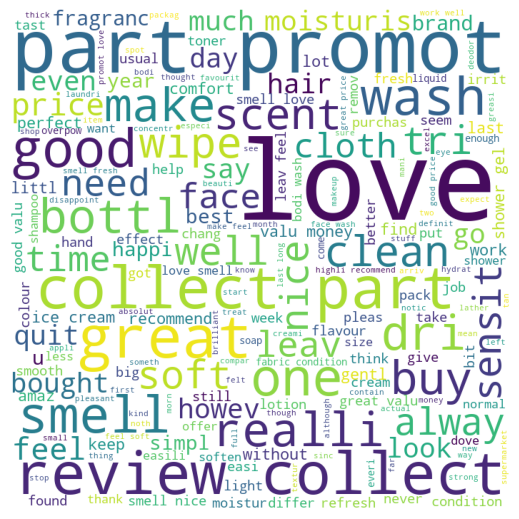

In [37]:
#WORDCLOUD - UPDATED TOP WORDS
words = '' 
for i in df["review_text"]: 
    tokens = i.split()   
    words += " ".join(tokens)+" "

    
word_cloud = WordCloud(width = 700, height = 700, background_color ='white', min_font_size = 10).generate(words) 
plt.figure(figsize = (5, 5)) 
plt.imshow(word_cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

After removing the top 3 common word (it was removed since it would remove its meaning from the entire thing), we are left with the current top 10 words. As seen from above, we can see that the sentiment of it is quite positive, meaning that this dataset is dealing with many positive-centric reviews. The general polarity is thus, positive, and needs to be kept in mind for analysis later. It is to be noted that due to the lack of negative reviews in this case can cause for there to be discrepencies when, for instance a negative value is set to be identified as "fake" or "real", and thus can be added as a limitation to this study.

In [38]:
df['review_text'].apply(word_tokenize).head()

0    [get, older, know, like, suitabl, bodi, like, ...
1    [three, gigant, marmit, jar, last, probabl, wh...
2                                              [excel]
3                    [great, flavour, top, slow, cook]
4                                                [say]
Name: review_text, dtype: object

In [39]:
#SAVING UPDATED DATAFRAME AS .csv FILE
df.to_csv('cleaned_data.csv')